In [1]:
import os
import pickle
import shutil
import re
import time
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from dataloader import GetDocumentObj, DictObj, GetTensor

In [2]:
USE_CUDA = torch.cuda.is_available()
GPU_ID = 1

USE_CUDA

True

In [3]:
top_path = "top_B.parse"
u20_path = "u20_B.parse"

In [4]:
label_dict = {top_path:0, u20_path:1}
list_document = []; start_date = None ; end_date = None
list_document, start_date, end_date = GetDocumentObj(list_document, top_path, label_dict[top_path], start_date, end_date)
list_document, start_date, end_date = GetDocumentObj(list_document, u20_path, label_dict[u20_path], start_date, end_date)

documents_obj = DictObj()
documents_obj.SetDict(list_document)    
time_tensor, loc_tensor, person_organ_tensor, morph_tensor, list_label = GetTensor(list_document, documents_obj, start_date, end_date)

len(list_label)

2274

In [5]:
# 갯수 맞추기
top_indices = [i for i, x in enumerate(list_label) if x == 0]
u20_indices = [i for i, x in enumerate(list_label) if x == 1]

top_doc_size = len(top_indices)
u20_doc_size = len(u20_indices)

print('탑 문서 수 : ', top_doc_size)
print('u20 문서 수 : ', u20_doc_size)

탑 문서 수 :  1821
u20 문서 수 :  453


In [6]:
# 나머지 뷰 갯수 맞추기
top_morph_list = [[morph_tensor[i], 0] for i in top_indices]
u20_morph_list = [[morph_tensor[i], 1] for i in u20_indices]

top_morph_list = random.sample(top_morph_list, u20_doc_size)

morph_list = top_morph_list + u20_morph_list
random.shuffle(morph_list)

morph_data = [data[0] for data in morph_list]
morph_data = torch.stack(morph_data, dim=0).cuda(GPU_ID)
morph_label = [data[1] for data in morph_list]

print('나머지 뷰 : ', morph_data.size())

나머지 뷰 :  torch.Size([906, 10802])


In [7]:
# 시간 뷰 갯수 맞추기
top_time_list = [[time_tensor[i], 0] for i in top_indices]
u20_time_list = [[time_tensor[i], 1] for i in u20_indices]

top_time_list = random.sample(top_time_list, u20_doc_size)

time_list = top_time_list + u20_time_list
random.shuffle(time_list)

time_data = [data[0] for data in time_list]
time_data = torch.stack(time_data, dim=0).cuda(GPU_ID)
time_label = [data[1] for data in time_list]

print('시간 뷰 : ', time_data.size())

시간 뷰 :  torch.Size([906, 180])


In [8]:
class SimpleAutoencoder(nn.Module):
    def __init__(self, input_size):
        super(SimpleAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, int(input_size/2)), nn.ReLU(True),
            nn.Linear(int(input_size/2), int(input_size/4)))
        self.decoder = nn.Sequential(
            nn.Linear(int(input_size/4), int(input_size/2)), nn.ReLU(True),
            nn.Linear(int(input_size/2), input_size), nn.ReLU())  # ReLU, Tanh

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def getRepresentation(self, x):
        x = self.encoder(x)
        return x

In [9]:
TOTAL_DATA_NUM = u20_doc_size*2
TRAIN_DATA_NUM = int(TOTAL_DATA_NUM*0.8)
TEST_DATA_NUM = TOTAL_DATA_NUM - TRAIN_DATA_NUM

In [10]:
def getBatch(data, batch_size=128, isTrain=True):
    if isTrain:
        startIdx = 0
        endIdx = TRAIN_DATA_NUM
    else:
        startIdx = TRAIN_DATA_NUM
        endIdx = len(data)
        
    for idx in range(startIdx, endIdx, batch_size):
        batch = data[idx:min(idx + batch_size, endIdx)]
        yield batch

In [11]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [12]:
def trainModel(model, inputs):
    BATCH_SIZE = 256
    NUM_EPOCH = 200
    
    LR = 1e-3
    WEIGHT_DECAY = 1e-5
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    print_every = NUM_EPOCH / 10
    plot_every = NUM_EPOCH / 20
    
    for epoch in tqdm(range(1, NUM_EPOCH+1)):
        for batch in getBatch(inputs, batch_size=BATCH_SIZE):
            batch = Variable(torch.FloatTensor(batch.tolist())).cuda(GPU_ID)
            # ===================forward=====================
            output = model(batch).cuda(GPU_ID)
            loss = criterion(output, batch)
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            print_loss_total += loss.data[0]
            plot_loss_total += loss.data[0]
            
        # ===================log========================
        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('epoch [{}/{}], loss:{:.5f}'.format(epoch, NUM_EPOCH, loss.data[0]))
        
        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    
    showPlot(plot_losses)
    #torch.save(model.state_dict(), './sim_autoencoder.pth')

In [13]:
def evalModel(model, inputs):
    BATCH_SIZE = 256
    
    criterion = nn.MSELoss()
    
    loss = 0
    result = []
    for batch in getBatch(inputs, batch_size=BATCH_SIZE, isTrain=False):
        batch = Variable(torch.FloatTensor(batch.tolist())).cuda(GPU_ID)
        
        output = model(batch).cuda(GPU_ID)
        result.append(output)
        loss += criterion(output, batch)[0]
        
    return loss, result

 10%|█         | 21/200 [00:02<00:17,  9.97it/s]

epoch [20/200], loss:0.02719


 20%|██        | 41/200 [00:03<00:13, 11.69it/s]

epoch [40/200], loss:0.02005


 30%|███       | 61/200 [00:04<00:10, 12.66it/s]

epoch [60/200], loss:0.01940


 40%|████      | 81/200 [00:06<00:09, 12.71it/s]

epoch [80/200], loss:0.01519


 52%|█████▏    | 103/200 [00:07<00:07, 13.22it/s]

epoch [100/200], loss:0.01406


 60%|██████    | 121/200 [00:09<00:05, 13.33it/s]

epoch [120/200], loss:0.01395


 72%|███████▏  | 143/200 [00:10<00:04, 13.31it/s]

epoch [140/200], loss:0.01196


 82%|████████▏ | 163/200 [00:12<00:02, 13.50it/s]

epoch [160/200], loss:0.00905


 92%|█████████▏| 183/200 [00:13<00:01, 13.56it/s]

epoch [180/200], loss:0.00692


100%|██████████| 200/200 [00:14<00:00, 13.66it/s]


epoch [200/200], loss:0.00691


<Figure size 432x288 with 0 Axes>

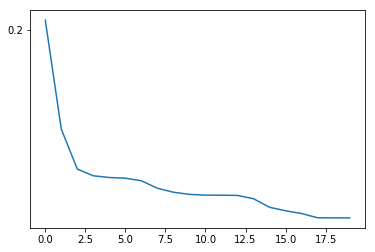

In [14]:
# 시간뷰 (180 dim)
inputs = time_data.cpu()   # ??????????????????????? cpu를 때보자 속도가 왜저럴까..
INPUT_SIZE = inputs.size()[1]

model_time = SimpleAutoencoder(INPUT_SIZE).cuda(GPU_ID)
trainModel(model_time, inputs)

 10%|█         | 20/200 [00:54<08:08,  2.71s/it]

epoch [20/200], loss:0.03279


 20%|██        | 40/200 [01:47<07:11,  2.70s/it]

epoch [40/200], loss:0.02812


 30%|███       | 60/200 [02:41<06:16,  2.69s/it]

epoch [60/200], loss:0.02632


 40%|████      | 80/200 [03:34<05:22,  2.69s/it]

epoch [80/200], loss:0.02574


 50%|█████     | 100/200 [04:28<04:28,  2.68s/it]

epoch [100/200], loss:0.02497


 60%|██████    | 120/200 [05:20<03:33,  2.67s/it]

epoch [120/200], loss:0.02464


 70%|███████   | 140/200 [06:14<02:40,  2.67s/it]

epoch [140/200], loss:0.02461


 80%|████████  | 160/200 [07:07<01:46,  2.67s/it]

epoch [160/200], loss:0.02436


 90%|█████████ | 180/200 [08:02<00:53,  2.68s/it]

epoch [180/200], loss:0.02459


100%|██████████| 200/200 [08:56<00:00,  2.68s/it]

epoch [200/200], loss:0.02425


<Figure size 432x288 with 0 Axes>

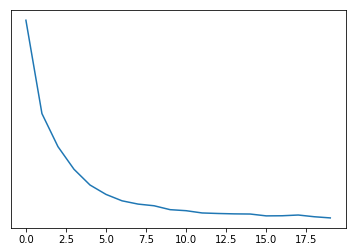

In [15]:
# 나머지뷰 (10802 dim)
inputs = morph_data.cpu()
INPUT_SIZE = inputs.size()[1]

model_morph = SimpleAutoencoder(INPUT_SIZE).cuda(GPU_ID)
trainModel(model_morph, inputs)

In [ ]:
results = []

results.append(evalModel(model_time, time_tensor))
results.append(evalModel(model_morph, morph_tensor))

[result[0].data.tolist()[0]/TEST_DATA_NUM for result in results]

In [17]:
# 직접 결과 보기 (시간뷰)

# 탑
test_input = torch.unsqueeze(top_time_list[0][0], dim=0).cuda()
test_input = Variable(torch.FloatTensor(test_input.tolist())).cuda(GPU_ID)
test_output = model_time(test_input)

In [18]:
with open("time_MSE_top.txt", "w") as f:
    compared_list = list(zip(np.round(test_input.data.tolist(), decimals=4).tolist()[0], np.round(test_output.data.tolist(), decimals=4).tolist()[0]))
    
    f.write('tgt gen\n')
    for compared in compared_list:
        f.write('{} {}\n'.format(compared[0], compared[1]))

In [19]:
# u20
test_input = torch.unsqueeze(u20_time_list[0][0], dim=0).cuda()
test_input = Variable(torch.FloatTensor(test_input.tolist())).cuda(GPU_ID)
test_output = model_time(test_input)

In [20]:
with open("time_MSE_u20.txt", "w") as f:
    compared_list = list(zip(np.round(test_input.data.tolist(), decimals=4).tolist()[0], np.round(test_output.data.tolist(), decimals=4).tolist()[0]))
    
    f.write('tgt gen\n')
    for compared in compared_list:
        f.write('{} {}\n'.format(compared[0], compared[1]))

In [21]:
# 직접 결과 보기 (나머지 뷰)

# 탑
test_input = torch.unsqueeze(top_morph_list[0][0], dim=0).cuda()
test_input = Variable(torch.FloatTensor(test_input.tolist())).cuda(GPU_ID)
test_output = model_morph(test_input)

In [22]:
with open("morph_MSE_top.txt", "w") as f:
    compared_list = list(zip(np.round(test_input.data.tolist(), decimals=4).tolist()[0], np.round(test_output.data.tolist(), decimals=4).tolist()[0]))
    
    f.write('tgt gen\n')
    for compared in compared_list:
        f.write('{} {}\n'.format(compared[0], compared[1]))

In [23]:
# u20
test_input = torch.unsqueeze(u20_morph_list[0][0], dim=0).cuda()
test_input = Variable(torch.FloatTensor(test_input.tolist())).cuda(GPU_ID)
test_output = model_morph(test_input)

In [24]:
with open("morph_MSE_u20.txt", "w") as f:
    compared_list = list(zip(np.round(test_input.data.tolist(), decimals=4).tolist()[0], np.round(test_output.data.tolist(), decimals=4).tolist()[0]))
    
    f.write('tgt gen\n')
    for compared in compared_list:
        f.write('{} {}\n'.format(compared[0], compared[1]))

In [ ]:
# K-means Clurstering
from sklearn.cluster import KMeans

# 시간 뷰 
# Train
inputs = Variable(next(getBatch(time_data, batch_size=TRAIN_DATA_NUM)))
batch_rep = model_time.getRepresentation(inputs).cpu().data.tolist()

In [ ]:
kmeans_time = KMeans(n_clusters=2, random_state=0).fit(batch_rep)
gen_label = kmeans_time.labels_

acc = sum(1 for gen, tar in zip(gen_label, time_label) if gen == tar) / TRAIN_DATA_NUM
acc

In [ ]:
# Evaluation
inputs = Variable(next(getBatch(time_data, batch_size=TEST_DATA_NUM, isTrain=False)))
batch_rep = model_time.getRepresentation(inputs).cpu().data.tolist()

In [ ]:
gen_label = kmeans_time.predict(batch_rep)

acc = sum(1 for gen, tar in zip(gen_label, time_label) if gen == tar) / TEST_DATA_NUM
acc

In [116]:
# 나머지 뷰
# Train
inputs = Variable(torch.FloatTensor(next(getBatch(morph_data, batch_size=TRAIN_DATA_NUM)).tolist())).cuda(GPU_ID)
batch_rep = model_morph.getRepresentation(inputs).cpu().data.numpy()

In [117]:
kmeans_morph = KMeans(n_clusters=2, random_state=0).fit(batch_rep)
gen_label = kmeans_morph.labels_

acc = sum(1 for gen, tar in zip(gen_label, morph_label) if gen == tar) / TRAIN_DATA_NUM
acc

3.967032967032967

In [118]:
# Evaluation
inputs = Variable(torch.FloatTensor(next(getBatch(morph_data, batch_size=TEST_DATA_NUM, isTrain=False)).tolist())).cuda(GPU_ID)
batch_rep = model_morph.getRepresentation(inputs).cpu().data.numpy()

In [ ]:
gen_label = kmeans_morph.predict(inputs)

acc = sum(1 for gen, tar in zip(gen_label, morph_label) if gen == tar) / TEST_DATA_NUM
acc